In [1]:
!nvidia-smi

Tue Feb  8 21:00:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 30%   34C    P8     4W / 350W |   2929MiB / 24259MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy       : 1.20.3
pandas      : 1.3.4
torch       : 1.10.0
transformers: 4.7.0



In [3]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random
import json
from math import isnan


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# New Section

In [4]:
# sns.countplot(df.label_norm)
# plt.xlabel('review score');

In [5]:
from transformers import BertTokenizer,BertModel
PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
# PRE_TRAINED_MODEL_NAME = "bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)
PRE_TRAINED_MODEL_NAME = '/home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin'

In [6]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [7]:
import ast

df_train = pd.read_csv('../data/pre/train.csv',sep='\t')
df_val = pd.read_csv('../data/pre/val.csv',sep='\t')
df_test = pd.read_csv('../data/pre/test.csv',sep='\t')
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')


df_train = df_train.drop(df_train.loc[df_train.verbA0A1.isna()].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1.isna()].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)

df_train = df_train.drop(df_train.loc[df_train.verbA0A1=='[]'].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1=='[]'].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1=='[]'].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

In [8]:


def string_to_tuples_list(text):
  if text is np.nan or text =='[]':
    return []
  text = ''.join(text.split('], ['))
  tmp = eval(text.strip('[').strip(']'))
  if not isinstance(tmp[0],tuple):
    return [tmp]
  return list(tmp)





for col in ['verb','A0','A1']:
  df_train[col] = df_train[col].apply(string_to_tuples_list)
  df_val[col] = df_val[col].apply(string_to_tuples_list)
  df_test[col] = df_test[col].apply(string_to_tuples_list)
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
# for col in ['verbA0A1']:
  df_train[col] = df_train[col].apply(ast.literal_eval)
  df_val[col] = df_val[col].apply(ast.literal_eval)
  df_test[col] = df_test[col].apply(ast.literal_eval)
  df_ood[col] = df_ood[col].apply(ast.literal_eval)



def mask(df):
  df = df.reset_index(drop = True)
  df['verb_mask'] = 0
  df['A0_mask'] = 0
  df['A1_mask'] = 0
  df['verb_mask'] = df['verb_mask'].astype('object')
  df['A0_mask'] = df['A0_mask'].astype('object')
  df['A1_mask'] = df['A1_mask'].astype('object')
  for index,row in df.iterrows():

    df.at[index,'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]
    AV_num = 0
    for k,col in enumerate(['verb','A0','A1']):
      masks = []
      for j in range(len(row['verbA0A1'])):
        mask = np.zeros(299)
        idx = []
        for v in row['verbA0A1'][j][k]:
          
          idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
        # idx = np.unique(idx).tolist()
        counter = Counter(idx)

        mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0,len(mask))]
        mask.insert(0,0)
        masks.append(mask)
      AV_num = len(masks)
      for i in range(10 - len(masks)):
        masks.append(np.zeros(300))
      while len(masks)>10:
        masks.pop()
      name = col+'_mask'
      df.at[index,name] = np.array(masks)
    if AV_num>10:
      AV_num=10
    df.loc[index,'AV_num'] = int(AV_num)
  df.AV_num = df.AV_num.astype('int')
#   df.stock_factors = df.stock_factors.apply(np.array)
  return df


df_train = mask(df_train)
df_test = mask(df_test)
df_val = mask(df_val)
df_ood = mask(df_ood)

In [9]:
max_len = 300
class_names = ['negative','neutral', 'positive']
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets,verb,A0,A1,AV_num,tokenizer,stock_factors, max_len):
    self.reviews = reviews
    self.targets = targets
    self.stock_factors = stock_factors
    self.verb = verb
    self.A0 = A0
    self.A1 = A1
    self.AV_num = AV_num
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    stock_factors = self.stock_factors[item]
    v = self.verb[item]
    a0 = self.A0[item]
    a1 = self.A1[item]
    av_num = self.AV_num[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'stock_factors':torch.tensor(stock_factors),
      'verb': torch.tensor(v),
      'A0': torch.tensor(a0),
      'A1': torch.tensor(a1),
      'AV_num': torch.tensor(av_num)
    }

In [10]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text_a.to_numpy(),
    targets=df.label.to_numpy(),
    stock_factors = df.stock_factors,
    verb = df.verb_mask,
    A0 = df.A0_mask,
    A1 = df.A1_mask,
    AV_num = df.AV_num,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4,
    shuffle=True
  )

In [11]:
# df_train.sample(n=4000).to_csv('/content/drive/MyDrive/data/df_train_srl.csv',sep='\t',index=None)
# df_test.sample(n=500).to_csv('/content/drive/MyDrive/data/df_test_srl.csv',sep='\t',index=None)
# df_val.sample(n=500).to_csv('/content/drive/MyDrive/data/df_val_srl.csv',sep='\t',index=None)

In [12]:
BATCH_SIZE = 16


df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_ood = df_ood.reset_index(drop=True)



train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

In [13]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,output_attentions=True)
    self.drop = nn.Dropout(p=0.1)
    self.sig = nn.Sigmoid()
    # self.relu = nn.ReLU()
    # self.L1 = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size//2)
    self.out1 = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[1]

#     print(result.keys())

#     attention_weight = torch.sum(result.attentions[11][:,:,:,:],1)[:,0,:]
#     print(pooled_output.keys())

#     output = torch.mean(pooled_output,1)
#     output = self.drop(pooled_output)
    # # output = self.L1(output)
#     output = self.out(output)
#     output = self.flatten(transformer_output.float())
    output = self.sig(pooled_output)
#     output = self.drop(output)
    output = self.out1(output)
    output = self.sig(output)
    output = self.drop(output)
    output = self.out(output)
 
    return output

In [14]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin and are new

In [15]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets', 'stock_factors', 'verb', 'A0', 'A1', 'AV_num'])

In [16]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 300])
torch.Size([16, 300])


In [17]:
output = model(input_ids, attention_mask)

# output.attentions[0][0].shape

# len(output.attentions)

# output.attentions[0][:,:,:,:]

# torch.sum(output.attentions[0][:,:,:,:],1)[:,1,:]

# output.attentions[0]

# F.softmax(output[0], dim=1)

In [18]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [19]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
history = defaultdict(list)
best_accuracy = 0
# EPOCHS = 5

In [22]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Pretrained_RoBERT.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.934487769100437 accuracy 0.5647905205247566
Val   loss 0.8654882125957037 accuracy 0.6215301286391334

Epoch 2/10
----------
Train loss 0.8067467890992378 accuracy 0.6622936944561997
Val   loss 0.8616948255928614 accuracy 0.6147596479350034

Epoch 3/10
----------
Train loss 0.7008250023418576 accuracy 0.7268726195514177
Val   loss 0.8612241357244471 accuracy 0.6431956668923493

Epoch 4/10
----------
Train loss 0.5949133494629427 accuracy 0.7862039779940753
Val   loss 0.9295115800954963 accuracy 0.6249153689911984

Epoch 5/10
----------
Train loss 0.5016715211922326 accuracy 0.833601354210749
Val   loss 0.9930993658240124 accuracy 0.6289776574136764

Epoch 6/10
----------
Train loss 0.43256351783246566 accuracy 0.8671180702496826
Val   loss 1.1028034667814932 accuracy 0.6174678402166554

Epoch 7/10
----------
Train loss 0.3738019661083112 accuracy 0.8913245873889124
Val   loss 1.1835269774160078 accuracy 0.6073121191604604

Epoch 8/10
----------
Train 

In [23]:
len(history["train_acc"])

10

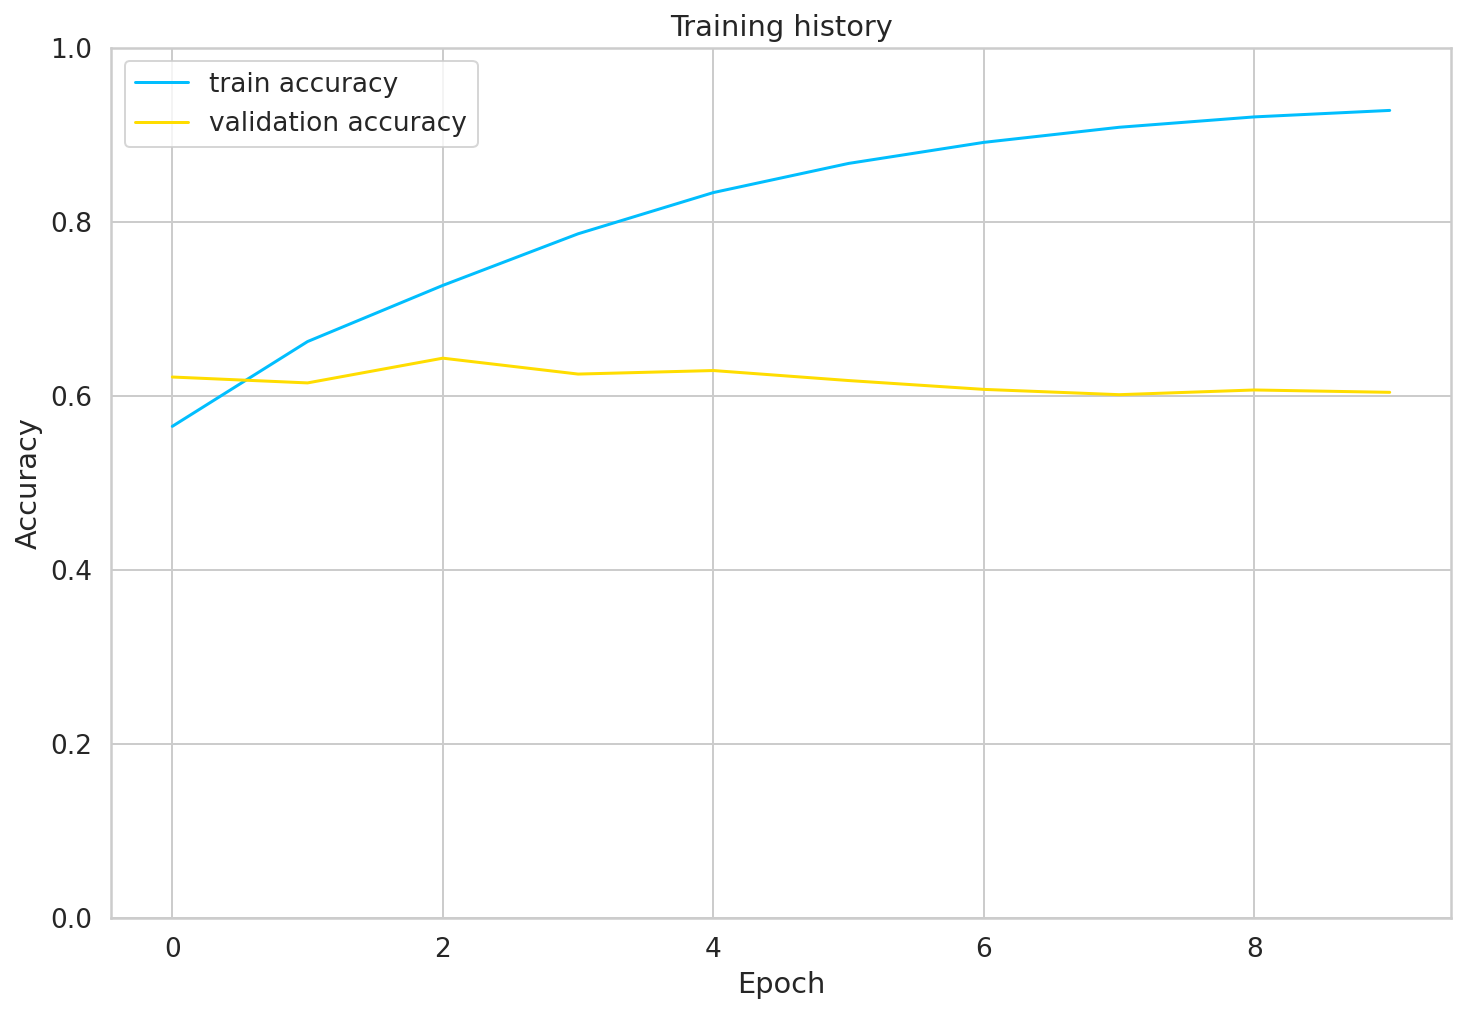

In [24]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [25]:
class_names={'negative','neutral','positive'}

In [26]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('Pretrained_RoBERT.bin'))
model = model.to(device)

Some weights of the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/bit/stock/model/pretrained-bert/ROBERT_4_model.bin and are new

In [27]:
len(df_test)

1477

In [28]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6384563303994584

In [29]:
text=df_test.loc[df_test.text_a.apply(len)<100].sample(n=1).text_a.values[0]

text_final = ''
for i in tokenizer.tokenize(text):
    tem = ' '+i
    text_final+=tem

text_final = text_final[1:]



#Credits to Lin Zhouhan(@hantek) for the complete visualization code
import random, os, numpy, scipy
from codecs import open
def createHTML(texts, weights, fileName):
    """
    Creates a html file with text heat.
weights: attention weights for visualizing
texts: text on which attention weights are to be visualized
    """
    fileName = "./visualization/"+fileName
    fOut = open(fileName, "w", encoding="utf-8")
    part1 = """
    <html lang="zh-Hans">
    <head>
    <meta http-equiv="content-type" content="text/html; charset=utf-8">
    <style>
    body {
    font-family: Sans-Serif;
    }
    </style>
    </head>
    <body>
    <h3>
    Heatmaps
    </h3>
    </body>
    <script>
    """
    part2 = """
    var color = "255,0,0";
    var ngram_length = 3;
    var half_ngram = 1;
    for (var k=0; k < any_text.length; k++) {
    var tokens = any_text[k].split(" ");
    var intensity = new Array(tokens.length);
    var max_intensity = Number.MIN_SAFE_INTEGER;
    var min_intensity = Number.MAX_SAFE_INTEGER;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = 0.0;
    for (var j = -half_ngram; j < ngram_length-half_ngram; j++) {
    if (i+j < intensity.length && i+j > -1) {
    intensity[i] += trigram_weights[k][i + j];
    }
    }
    if (i == 0 || i == intensity.length-1) {
    intensity[i] /= 2.0;
    } else {
    intensity[i] /= 3.0;
    }
    if (intensity[i] > max_intensity) {
    max_intensity = intensity[i];
    }
    if (intensity[i] < min_intensity) {
    min_intensity = intensity[i];
    }
    }
    var denominator = max_intensity - min_intensity;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = (intensity[i] - min_intensity) / denominator;
    }
    if (k%2 == 0) {
    var heat_text = "<p><br><b>Example:</b><br>";
    } else {
    var heat_text = "<b>Example:</b><br>";
    }
    var space = " ";
    for (var i = 0; i < tokens.length; i++) {
    heat_text += "<span style='background-color:rgba(" + color + "," + intensity[i] + ")'>"  + tokens[i] + "</span>";
    if (space == "") {
    space = " ";
    }
    }
    //heat_text += "<p>";
    document.body.innerHTML += heat_text;
    }
    </script>
    </html>"""
    putQuote = lambda x: "\"%s\""%x
    textsString = "var any_text = [%s];\n"%(",".join(map(putQuote, texts)))
    weightsString = "var trigram_weights = [%s];\n"%(",".join(map(str,weights)))
#     print(part1)
#     print(textsString)
#     print(part2)
#     print(weightsString)
    fOut.write(part1)
    fOut.write(textsString)
    fOut.write(weightsString)
    fOut.write(part2)
    fOut.close()
  
    return
# ===================================================
# 2. add text and get weight
# ===================================================
text1 = text_final
tok = tokenizer.tokenize(text1)
# text2 = 'NEWS'
# p_pos = len(tok1)
# tok2 = tokenizer.tokenize(text2)
# tok = tok1+tok2


ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cuda')

with torch.no_grad():
    output = model.bert(ids)
attentions = torch.cat(output[2]).to('cpu')

# =================================================
# 3. creat html attention heat map
# =================================================
createHTML([text1],[attentions[11,3,0,1:-2].numpy().tolist()],'Pretrained_RoBERT.html')


In [35]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs,attention_weight = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [36]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [37]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names,digits = 4))


cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

ValueError: too many values to unpack (expected 2)

In [ ]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [ ]:
df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-01-01')&(df_ood.DATE<='2021-03-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-04-01')&(df_ood.DATE<='2021-06-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-07-01')&(df_ood.DATE<='2021-09-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('../data/pre/ood.csv',sep='\t')
df_ood = df_ood.loc[df_ood.DATE>='2021-10-01']
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)
plt.show()

In [ ]:
df_ood = pd.read_csv('../data/df_all_year_srl.csv',sep='\t')
# df_ood = df_ood.loc[(df_ood.DATE>='2021-05-05')&(df_ood.DATE<='2021-09-01')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [ ]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Pretrained_RoBERT_ood.csv',sep='\t')

In [42]:
attentions.shape

torch.Size([12, 12, 21, 21])

tensor([2.8402e-01, 7.1909e-04, 4.5326e-04, 5.8260e-04, 2.7815e-04, 4.4859e-04,
        9.1372e-05, 2.2415e-04, 8.7482e-04, 4.5409e-04, 1.6643e-04, 1.2955e-04,
        1.2003e-04, 1.4995e-04, 8.3879e-05, 4.0293e-04, 2.8941e-04, 3.7290e-04,
        7.9863e-05, 3.3022e-05, 2.3064e-05, 3.1803e-05, 2.4699e-04, 1.3086e-05,
        7.5363e-05, 7.2647e-03, 4.9079e-03, 6.1403e-04, 8.2005e-05, 1.3443e-05,
        1.2104e-04, 9.3161e-05, 2.6931e-05, 1.9461e-04, 1.8966e-04, 1.4323e-04,
        9.9127e-04, 1.3449e-03, 1.9431e-04, 1.6325e-04, 9.6167e-05, 1.0240e-04,
        1.5174e-04, 1.3471e-04, 4.1739e-04, 3.3537e-04, 4.6076e-04, 1.6956e-05,
        2.1069e-05, 2.2673e-05, 8.6017e-06, 3.4207e-06, 7.1421e-05, 2.2800e-05,
        1.6190e-05, 1.9587e-03, 1.7212e-03, 1.2913e-04, 1.6248e-04, 1.4696e-05,
        2.5823e-04, 1.9354e-03, 2.6211e-02, 4.6574e-02, 1.6566e-03, 3.5978e-04,
        1.0916e-03, 1.2072e-03, 1.5310e-02, 2.7473e-03, 3.7834e-03, 1.5960e-01,
        6.1466e-02, 1.5899e-02, 1.6952e-

In [ ]:
# !pip install lit-nlp

In [ ]:
# from lit_nlp.api.dataset import Dataset
# class MultiNLIData(Dataset):
#   """Loader for MultiNLI development set."""
#   def __init__(self, df):
#     # Read the eval set from a .tsv file as distributed with the GLUE benchmark.
#     # df = pandas.read_csv(path, sep='\t')
#     # Store as a list of dicts, conforming to self.spec()
#     self.LABELS = [0,1]
#     self._examples = [{
#       'sentence': row['DESCRIPTION_EN'],
#       # 'hypothesis': row['sentence2'],
#       'label': row['LABEL']
#       # 'genre': row['genre'],
#     } for _, row in df.iterrows()]
#   def spec(self):
#     return {
#       'sentence': lit_types.TextSegment(),
#       # 'hypothesis': lit_types.TextSegment(),
#       'label': lit_types.CategoryLabel(vocab=self.LABELS),
#       # We can include additional fields, which don't have to be used by the model.
#       # 'genre': lit_types.Label(),
#     }

In [ ]:
# from absl import app
# from absl import flags
# from absl import logging

# from lit_nlp import dev_server
# from lit_nlp import server_flags
# from lit_nlp.api import model as lit_model
# from lit_nlp.api import types as lit_types
# # Use the regular GLUE data loaders, because these are very simple already.
# from lit_nlp.examples.datasets import glue
# from lit_nlp.lib import utils

# import torch
# import transformers

# # NOTE: additional flags defined in server_flags.py

# FLAGS = flags.FLAGS

# flags.DEFINE_string(
#     "model_path",
#     "https://storage.googleapis.com/what-if-tool-resources/lit-models/sst2_tiny.tar.gz",
#     "Path to trained model, in standard transformers format, e.g. as "
#     "saved by model.save_pretrained() and tokenizer.save_pretrained()")


# def _from_pretrained(cls, *args, **kw):
#   """Load a transformers model in PyTorch, with fallback to TF2/Keras weights."""
#   try:
#     return cls.from_pretrained(*args, **kw)
#   except OSError as e:
#     logging.warning("Caught OSError loading model: %s", e)
#     logging.warning(
#         "Re-trying to convert from TensorFlow checkpoint (from_tf=True)")
#     return cls.from_pretrained(*args, from_tf=True, **kw)


# class SimpleSentimentModel(lit_model.Model):
#   """Simple sentiment analysis model."""

#   LABELS = [0,1]  # negative, positive

#   def __init__(self, model_name_or_path):
#     self.tokenizer = transformers.AutoTokenizer.from_pretrained(
#         model_name_or_path)
#     model_config = transformers.AutoConfig.from_pretrained(
#         model_name_or_path,
#         num_labels=2,
#         output_hidden_states=True,
#         output_attentions=True,
#     )
#     # This is a just a regular PyTorch model.
#     self.model = _from_pretrained(
#         transformers.AutoModelForSequenceClassification,
#         model_name_or_path,
#         config=model_config)
#     self.model.eval()

#   ##
#   # LIT API implementation
#   def max_minibatch_size(self):
#     # This tells lit_model.Model.predict() how to batch inputs to
#     # predict_minibatch().
#     # Alternately, you can just override predict() and handle batching yourself.
#     return 16

#   def predict_minibatch(self, inputs):
#     # Preprocess to ids and masks, and make the input batch.
#     encoded_input = self.tokenizer.batch_encode_plus(
#         [ex["sentence"] for ex in inputs],
#         return_tensors="pt",
#         add_special_tokens=True,
#         max_length=200,
#         padding="longest",
#         truncation="longest_first")

#     # Check and send to cuda (GPU) if available
#     if torch.cuda.is_available():
#       self.model.cuda()
#       for tensor in encoded_input:
#         encoded_input[tensor] = encoded_input[tensor].cuda()
#     # Run a forward pass.
#     with torch.no_grad():  # remove this if you need gradients.
#       out: transformers.modeling_outputs.SequenceClassifierOutput = \
#           self.model(**encoded_input)

#     # Post-process outputs.
#     batched_outputs = {
#         "probas": torch.nn.functional.softmax(out.logits, dim=-1),
#         "input_ids": encoded_input["input_ids"],
#         "ntok": torch.sum(encoded_input["attention_mask"], dim=1),
#         "cls_emb": out.hidden_states[-1][:, 0],  # last layer, first token
#     }
#     # Return as NumPy for further processing.
#     detached_outputs = {k: v.cpu().numpy() for k, v in batched_outputs.items()}
#     # Unbatch outputs so we get one record per input example.
#     for output in utils.unbatch_preds(detached_outputs):
#       ntok = output.pop("ntok")
#       output["tokens"] = self.tokenizer.convert_ids_to_tokens(
#           output.pop("input_ids")[1:ntok - 1])
#       yield output

#   def input_spec(self) -> lit_types.Spec:
#     return {
#         "sentence": lit_types.TextSegment(),
#         "label": lit_types.CategoryLabel(vocab=self.LABELS, required=False)
#     }

#   def output_spec(self) -> lit_types.Spec:
#     return {
#         "tokens": lit_types.Tokens(),
#         "probas": lit_types.MulticlassPreds(parent="label", vocab=self.LABELS),
#         "cls_emb": lit_types.Embeddings()
#     }


In [ ]:
# dataset = MultiNLIData(df_train.sample(1800))

In [ ]:
# datasets = {"sst_dev": dataset}
# models = {"sst": SimpleSentimentModel("/content/drive/MyDrive/model/best_model/")}
# # models = {"sst": SimpleSentimentModel("bert-base-uncased")}

In [ ]:
# from lit_nlp import notebook
# widget = notebook.LitWidget(models, datasets, height=800)

In [ ]:
# mm = models["sst"]

In [ ]:
# mm.model.config

In [ ]:
# widget.render()

In [ ]:
# dataset.LABELS


In [ ]:
# df.loc[df.NAME=="三角防务"]